## Benchmark Testing with QHDOPT

In this notebook, we demonstrate the performance of QHDOPT using a set of nonlinear and nonconvex optimization problems. We design a benchmark test consisting of 15 randomly generated nonlinear optimization problem instances:

- Problem instances 1 - 5 are nonlinear programming (NLP) problems involving two or three continuous variables,
- Problem instances 6 - 10 are quadratic programming (QP) problems drawn from the benchmark devised in [the original QHD paper](https://arxiv.org/abs/2303.01471), 
- Problem instances 11 - 15 are nonlinear programming (NLP) problems involving exponential functions. 

For a detailed description of the test instances, see Section 6 in [arXiv:2409.03121](https://arxiv.org/abs/2409.03121).

### 1. Load problem instances

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, log, exp

from qhdopt import QHD
from benchmark_utils import run_test, compare_coarse_and_refine, make_violin_plot

In [2]:
problem_instances = []

def get_Q_b(problem_num):
    with open(f"resources/50d_instance{problem_num}.npy", 'rb') as f:
        Q = np.load(f)
        b = np.load(f)
    return Q, b

def create_sympy_func(Q, b):
    x = symbols(f"x:{len(Q)}")
    f = 0
    for i in range(len(Q)):
        qii = Q[i][i]
        bi = b[i]
        f += 0.5 * qii * exp(x[i]) * exp(x[i]) + bi * exp(-x[i])
    for i in range(len(Q)):
        for j in range(i + 1, len(Q)):
            f += Q[i][j] * exp(x[i]) * exp(x[j])
    return f, list(x)

In [3]:
x, y, z = symbols('x y z')

functions = [
            (-4*x**2 + 3*x*y - 2 * y ** 2 + 3 * x - y, [x, y]),
            (-2*(x-1/3)**2 + y**2 -y*log(3*x + 1/2)/3 + 5*(x**2 - y**2 - x - 0.5)**2, [x, y]),
             (y**1.5 - (y-0.75)*exp(4*x),  [x, y]),
             ((2*y-1)**2*(z-0.4) - (2*x-1)*z + (2*x-1.5)**2*y, [x, y, z]),
             (2*exp(-x) * (2*z-1)**2 - 3*(2*y-0.7)**2 * exp(-z) + log(x + 1) * (y-0.8), [x, y, z]),
             ]

QP_problems = [get_Q_b(i) for i in range(1,6)]

The last 10 problems are created from NPY files.

In [4]:
# The first 5 problems are created using symbolic expressions.
for i in range(5):
    function, syms = functions[i]
    model = QHD.SymPy(function, syms)
    problem_instances.append(model)
    print(f"Test problem {i+1} is created.")

# Test problems 6 -10 are created using the data from NPY files.
for i in range(5):
    model = QHD.QP(*QP_problems[i])
    problem_instances.append(model)
    print(f"Test problem {i+6} is created.")

# The last 5 problems are created using symbolic expressions with data from NPY files.
for i in range(5):
    model = QHD.SymPy(*create_sympy_func(*QP_problems[i]))
    problem_instances.append(model)
    print(f"Test problem {i+11} is created.")

Test problem 1 is created.
Test problem 2 is created.
Test problem 3 is created.
Test problem 4 is created.
Test problem 5 is created.
Test problem 6 is created.
Test problem 7 is created.
Test problem 8 is created.
Test problem 9 is created.
Test problem 10 is created.
Test problem 11 is created.
Test problem 12 is created.
Test problem 13 is created.
Test problem 14 is created.
Test problem 15 is created.


### 2. Solve with D-Wave & classical optimizers

In [3]:
# solver parameters

resolution = 8
anneal_schedule = [[0,0],[20, 1]]
numruns = 1000
backend = "dwave"
tol = 1e-3
penalty_coefficient = 3e-2
penalty_ratio = 1.2
api_key_file = "dwave_api_key.txt" 
embedding_scheme = "unary"

In [ ]:
data = np.zeros((len(functions), 16))
time_vals = []

for i in range(0, len(problem_instances)):
    print(f"Running test problem {i}:")
    model = problem_instances[i]
    model.dwave_setup(resolution, numruns, api_key_from_file=api_key_file, embedding_scheme=embedding_scheme, anneal_schedule=anneal_schedule, penalty_coefficient=penalty_coefficient, penalty_ratio=penalty_ratio, post_processing_method="IPOPT")
    data[i], i_times = run_test(model)
    time_vals.append(i_times)

### 3. Investigate the role of refinement

Another interesting finding is that the classical refinement times of quantum-generated samples are significantly shorter than the average runtime of the direct use of local optimizers.
To further investigate this phenomenon, we plot the distribution of objective function values corresponding to three different sample groups, including 
1. randomly generated initial guesses, 
2. quantum (D-Wave) generated samples, and 
3. TNC refined samples (using quantum-generated samples as initial guesses).

The results are shown in the following code block. Note that we only plot objective function values for high-dimensional problems, i.e., test instances 6 - 15.

In [5]:
plot_data = []

for i in range(10): # index starting from 6
    print(f"Test instance {i+6}:")
    if i < 5:
        model = QHD.QP(*QP_problems[i])
    else:
        model = QHD.SymPy(*create_sympy_func(*QP_problems[i-5]))
    model.dwave_setup(resolution, 
                      numruns, 
                      api_key_from_file=api_key_file, 
                      embedding_scheme=embedding_scheme, 
                      anneal_schedule=anneal_schedule,
                      post_processing_method="TNC")
    data = compare_coarse_and_refine(i+6, model)
    plot_data.append(data)

Test instance 6:
Backend QPU Time: 0.19772636
Overhead Time: 7.568086037003174

* Runtime breakdown
SimuQ compilation: 0.001 s
Backend runtime: 7.766 s
Decoding time: 0.286 s
Classical (Fine-tuning) time: 2.780 s
* Total time: 10.833 s

* Coarse solution
Minimizer: [0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  1.  1.
 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.
 1.  1.  0.  0.  0.  0.5 1.  0.  0.  0.  0.  0.  0.  0. ]
Minimum: -1.1873167707228696

* Fine-tuned solution
Minimizer: [0.         0.         0.         0.         0.         0.
 0.         0.         1.         1.         0.         1.
 0.         0.         0.         0.         1.         1.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.         1.         0.
 1.         1.         0.         0.         0.         0.59351027
 1.         0.         0.         0.         0. 

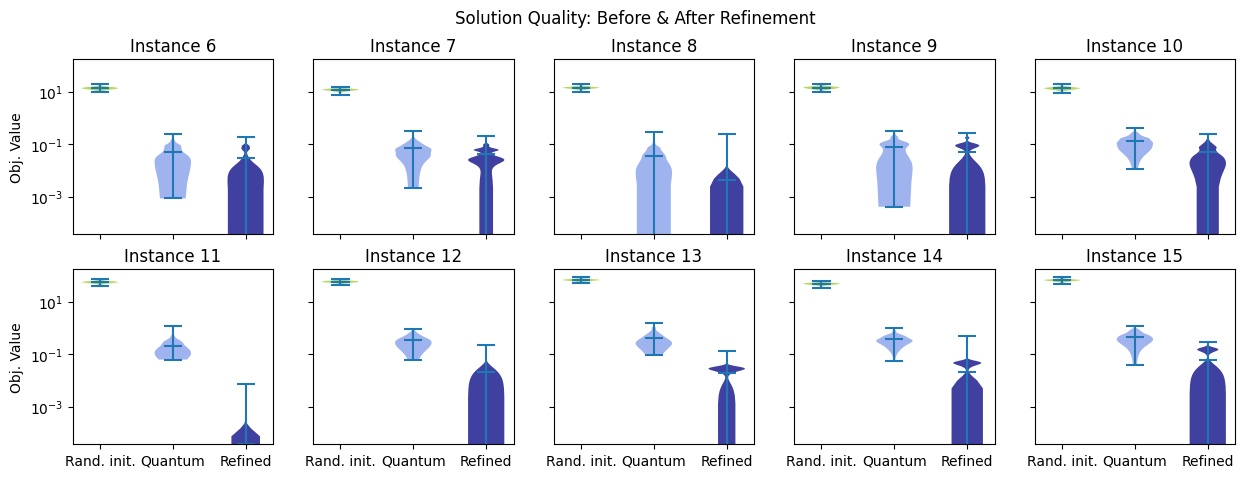

In [7]:
# visualize results using violin plot 
make_violin_plot(plot_data, savefig=True)

**Interpretation:**

While the quantum-generated solutions are limited by low precision, it is observed that they are still qualitatively better than random initial guesses. 

In the subsequent post-processing, QHDOPT performs a local search subroutine to refine solution quality by improving numerical accuracy. 
In other words, the quantum sampler in QHDOPT can be regarded as a fast and efficient warm-start that devises initial guesses of better quality.